# Syncronizing particles

We have seen problem building averages over all particles for each step, as such an idea of having a value for each particle at a certain "time" or distance travelled d doesn't exist with variable step length.

The idea is now to force such a synchronous state where every particle comes through the same value of d. In between those synced states CRPropa can do whatever variable step length is needed to be precise. But we don't analyze these in-between-movement but the synced states only.

Our first observation is pretty obvious. Every particle started at d = 0 as we did not add noise to starting points. And every particle ended at a distance d equal to set `MaximumTrajectoryLength(d_end)`

The idea is to take only those two values into the analysis data. Of cource we reduce the maximum length a lot. And then wo do another run setting d_end just a little further.

The question now is: Do we need to start from 0 for the second run or are we able to resume simulation with the positions every particle had on the end of first run?

We will have a look at a simple CRPropa simulation but stay with PropagationCK and then try to resume a second run. Since we do not want to output every calculated step we just drop the output module and collect the values after the sync-step in python. To do this we need access to the candidates, that you usually don't have in a normal simulation run. We could create a module that acts as output to collect last state only and then also acts as source to next run to not create new candidates but reuse previous ones instead. For the moment we will manually create a list of candidates and do the simulation loops.

In [1]:
from crpropa import *
import numpy as np

#number of candidates
N = 2
#number of sync-steps
n = 500
#overall max trajectory length
max_trajectory_length = 100 * Mpc

sync_step = max_trajectory_length / n

randomSeed = 42
vgrid = VectorGrid(Vector3d(0), 256, 30*kpc)
initTurbulence(vgrid, 10*nG, 100*kpc, 1000*kpc, -11./3., randomSeed)
Bfield = MagneticFieldGrid(vgrid)

prop = PropagationCK(Bfield)

source = Source()
source.add(SourceParticleType(nucleusId(1, 1)))
source.add(SourcePowerLawSpectrum(1*EeV, 1*EeV, -1))
source.add(SourceIsotropicEmission())
source.add(SourcePosition(Vector3d(0, 0, 0)*Mpc))

candidates = []
for i in range(0,N):
    candidates.append(source.getCandidate())

data = np.empty([0,4]) # first attempt with a litte bug, see later
data_fixed = np.empty([0,4]) # corrected attempt with fixed trajectory length
for s in range(1,n+1):
    stop = MaximumTrajectoryLength(s * sync_step)
    for c in candidates:
        c.setActive(True);
        while c.isActive():
            prop.process(c.get())
            stop.process(c.get())
        pos = c.current.getPosition()
        data = np.append(data, [[c.getTrajectoryLength(), pos.getX(), pos.getY(), pos.getZ()]], axis=0)
        data_fixed = np.append(data_fixed, [[s * sync_step, pos.getX(), pos.getY(), pos.getZ()]], axis=0)

# data in Mpc
data = data / Mpc;
data_fixed = data_fixed / Mpc;

This replaced the simulation run and storing trajectory into data. Now we can try our analysis plot, having our data array already populated.

<IPython.core.display.Javascript object>


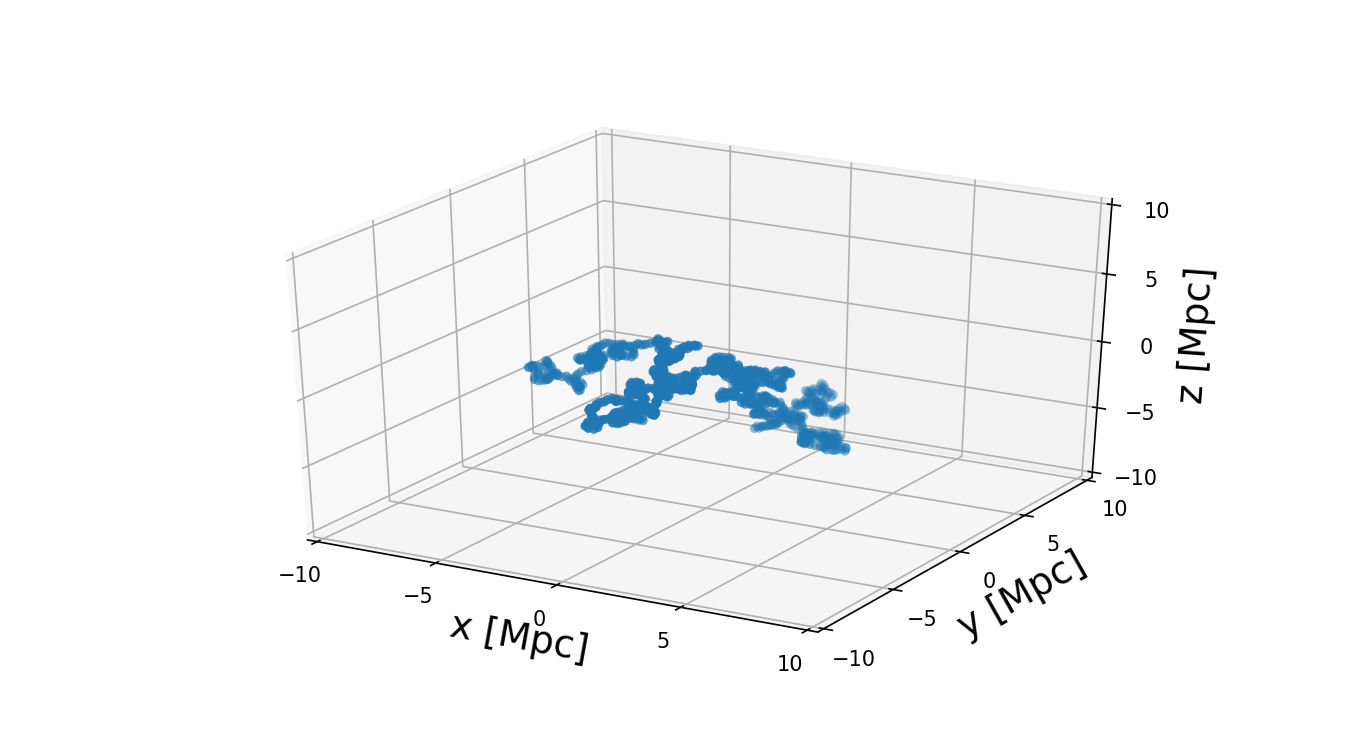

In [2]:
%matplotlib notebook
from pylab import *
from mpl_toolkits.mplot3d import axes3d

# trajectory points
x, y, z = data[:,1], data[:,2], data[:,3]

fig = plt.figure(figsize=(9, 5))#plt.figaspect(0.5))
ax = fig.gca(projection='3d')# , aspect='equal'

ax.scatter(x,y,z, 'o', lw=0)

ax.set_xlabel('x [Mpc]', fontsize=18)
ax.set_ylabel('y [Mpc]', fontsize=18)
ax.set_zlabel('z [Mpc]', fontsize=18)
ax.set_xlim((-10, 10))
ax.set_ylim((-10, 10))
ax.set_zlim((-10, 10))
ax.xaxis.set_ticks((-10, -5, 0, 5, 10))
ax.yaxis.set_ticks((-10, -5, 0, 5, 10))
ax.zaxis.set_ticks((-10, -5, 0, 5, 10))

show()

Here we can see movement of 2 particles that look pretty continous. Stopping and resuming the simulation in a self-implemented loop does not cause any effects like restting the candidate. Looks like a solution we can now work with.

In [3]:
from collections import defaultdict

grouped = defaultdict(list)
d = []
r_sq = []
d_end = 0
#print(data.dtype.names)
for di, X, Y, Z in data:
    grouped[di].append(X**2 + Y**2 + Z**2)
for di in grouped: 
    d.append(di)
    r_sq.append(np.mean(grouped[di]))
    d_end = max(d_end, di)
print('After last step:')
print('r_min   = ' + str(sqrt(np.min(grouped[d_end]))))
print('r_max   = ' + str(sqrt(np.max(grouped[d_end]))))
r_avg = np.mean(sqrt(grouped[d_end]))
print('< r >   = ' + str(r_avg))
print('< r >²  = ' + str(r_avg**2))
r_sq_avg = np.mean(grouped[d_end])
print('< r² >  = ' + str(r_sq_avg))
print('sigma_r = ' + str(sqrt(abs(r_sq_avg - r_avg**2))))


After last step:
r_min   = 4.94150333686
r_max   = 6.08820318982
< r >   = 5.51485326334
< r >²  = 30.4136065162
< r² >  = 30.7423366544
sigma_r = 0.573349926482


And then the curve fit and diffusion constant.

In [4]:
from scipy.optimize import curve_fit

def func(x, a, b):
    return a*(x**b)

popt, pcov = curve_fit(func, d, r_sq, bounds=(0, [4.0, 2.0]))
D = popt[0]
alpha = popt[1]
print('D = ' + str(D))
print('alpha = ' + str(alpha))
print()
print('r_sq = ' + str(D) + ' d ^ ' + str(alpha))

D = 0.464349685754
alpha = 0.919872443893

r_sq = 0.464349685754 d ^ 0.919872443893


<IPython.core.display.Javascript object>


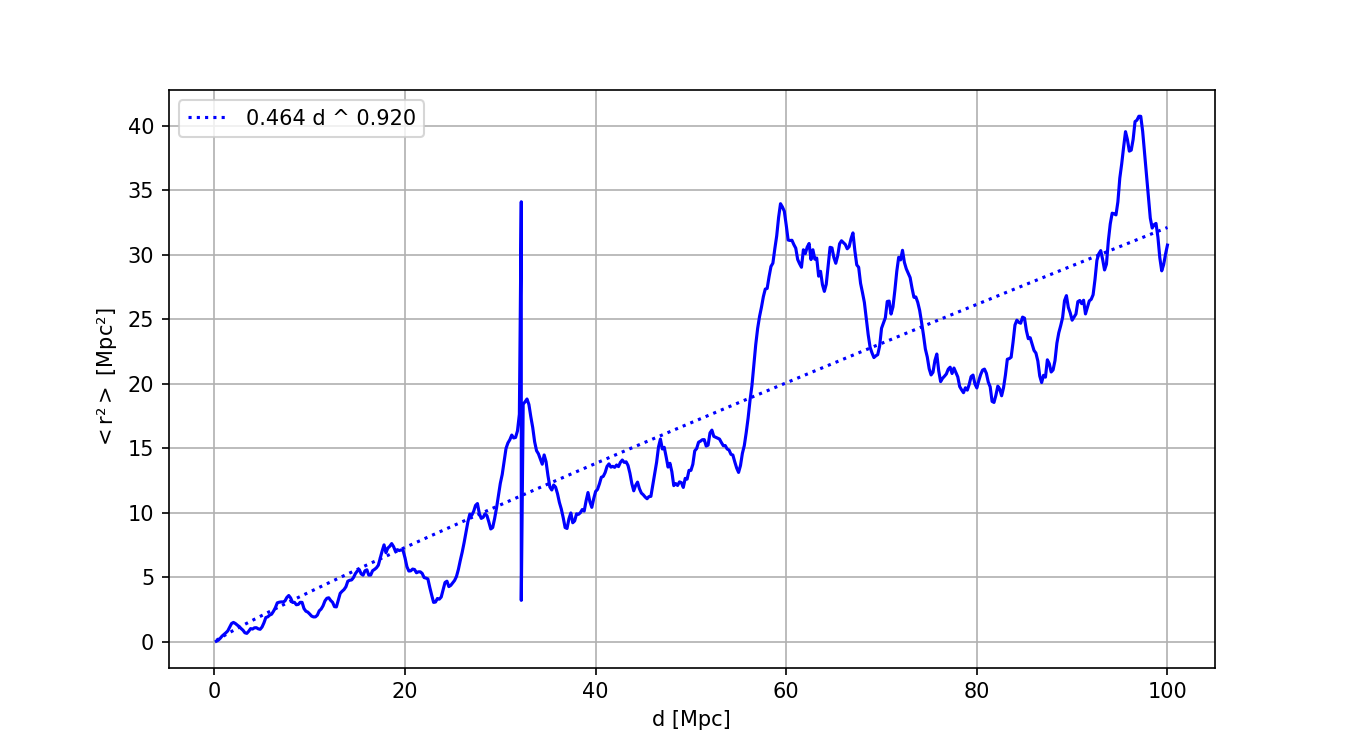

In [5]:
figure(figsize=(9, 5))
plot(d, r_sq, 'b-')
plot(d, func(d, D, alpha), 'b:', label='%.3f d ^ %.3f' % tuple(popt))
grid()
ylabel('$<$r²$>$ [Mpc²]')
xlabel('d [Mpc]')
legend()
show()

This looks much better than the first attempt. But we can see that from our many sync-steps just a few resulted in not exactly the same value for d, possibly for numeric reasons.

We can fix this by enforcing a fixed d value as we already knew it by setting the max trajectory length for that step.

<IPython.core.display.Javascript object>


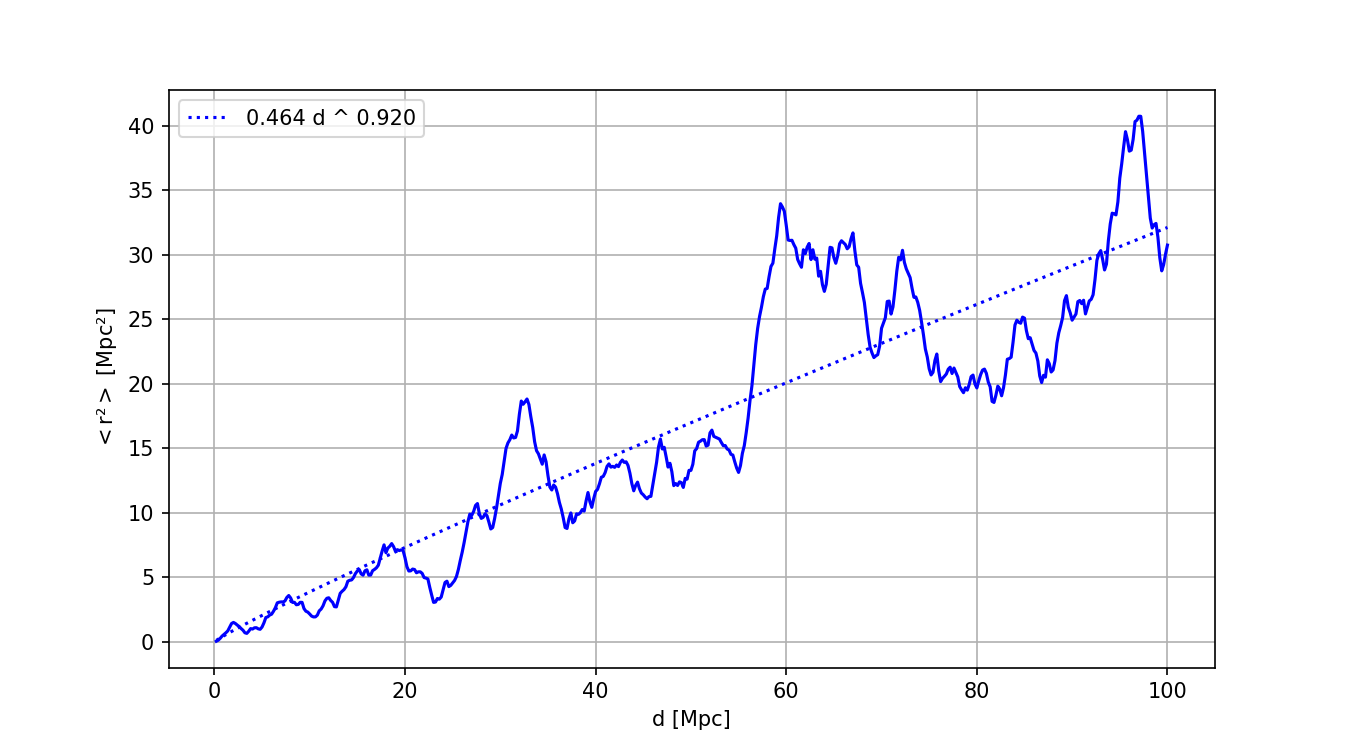

In [6]:
grouped = defaultdict(list)
d = []
r_sq = []
d_end = 0
#print(data.dtype.names)
for di, X, Y, Z in data_fixed:
    grouped[di].append(X**2 + Y**2 + Z**2)
for di in grouped: 
    d.append(di)
    r_sq.append(np.mean(grouped[di]))
    d_end = max(d_end, di)

figure(figsize=(9, 5))
plot(d, r_sq, 'b-')
plot(d, func(d, D, alpha), 'b:', label='%.3f d ^ %.3f' % tuple(popt))
grid()
ylabel('$<$r²$>$ [Mpc²]')
xlabel('d [Mpc]')
legend()
show()

Here we used too few particles to judge the result for physical aspects like the fir not being linear. We just showed a method to clean up our analysis plot. We now can apply this method to a larger set of particles and some collection of different B field setups.